In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import display
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image

In [2]:
# thư mục gốc chứa thư mục dữ liệu
szWorkingDir = "/kaggle/input/cs114-ml"

# dùng để hiển thị
nNumImgsPerRow = 10
nImgHeight = nImgWidth = 150

In [3]:
# mapping
labels = {
    'Others': 0,
    'Honda': 1,
    'Hyundai': 2,
    'KIA': 3,
    'Mazda': 4,
    'Mitsubishi': 5,
    'Suzuki': 6,
    'Toyota': 7,
    'VinFast': 8
}
reverse_map_labels = {
    0: 'Others',
    1: 'Honda',
    2: 'Hyundai',
    3: 'KIA',
    4: 'Mazda',
    5: 'Mitsubishi',
    6: 'Suzuki',
    7: 'Toyota',
    8: 'VinFast'
}

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
szWorkingDir = "/kaggle/input/cs114-ml"
path_img = os.path.join(szWorkingDir, "dataset")

In [6]:
# Đọc file lỗi
error = pd.read_csv(os.path.join(szWorkingDir, "ImageErrors.csv"))
error_paths = error.iloc[:, 0].unique().tolist()  # Lấy danh sách đường dẫn ảnh lỗi

In [7]:
# Đọc các tập dữ liệu split
csv_dir = os.path.join(szWorkingDir, "car_split/car_split")

In [8]:
# Hàm xử lý dữ liệu cho từng fold
def prepare_data_for_fold(fold_num, error_paths):
    # Đọc file train và test cho fold
    img_path_train = os.path.join(csv_dir, f"CarDataset-Splits-{fold_num}-Train.csv")
    img_path_test = os.path.join(csv_dir, f"CarDataset-Splits-{fold_num}-Test.csv")
    
    # Đọc dữ liệu train và test
    dataTrain = pd.read_csv(img_path_train)
    dataTest = pd.read_csv(img_path_test)

    # Loại bỏ ảnh lỗi trong cả train và test
    dataTrain = dataTrain[~dataTrain['ImageFullPath'].isin(error_paths)]
    dataTest = dataTest[~dataTest['ImageFullPath'].isin(error_paths)]

    # Đọc các nhóm ảnh trùng từ file CheckDuplicate
    checkduplicate_file = os.path.join(szWorkingDir, f"CheckDuplicate/CheckDuplicate_Train_{fold_num}.csv")
    duplicates_df = pd.read_csv(checkduplicate_file)
    
    # Loại bỏ ảnh trùng
    duplicate_groups = duplicates_df.groupby('ClusterID')['ImageFullPath'].agg(list)
    for group in duplicate_groups:
        if len(group) > 1:
            # Chọn ngẫu nhiên 1 ảnh giữ lại
            keep_image = np.random.choice(group, 1)[0]
            # Lấy các ảnh cần loại bỏ
            remove_images = [img for img in group if img != keep_image]
            # Loại bỏ ảnh trùng trong DataFrame
            dataTrain = dataTrain[~dataTrain['ImageFullPath'].isin(remove_images)]
    
    # Đường dẫn ảnh cho train và test
    train_images = [os.path.join(path_img, img) for img in dataTrain['ImageFullPath']]
    train_labels = dataTrain['CategoryID'].tolist()
    
    test_images = [os.path.join(path_img, img) for img in dataTest['ImageFullPath']]
    test_labels = dataTest['CategoryID'].tolist()

    # Chia dữ liệu train thành train và validation
    train_X, val_X, train_Y, val_Y = train_test_split(train_images, train_labels, test_size=0.2, random_state=30)
    
    # In ra số lượng lớp trong tập train và validation
    print(f"Fold {fold_num}:")
    print(f"Train label count: {Counter(train_Y)}")
    print(f"Validation label count: {Counter(val_Y)}")
    
    return train_X, val_X, train_Y, val_Y, test_images, test_labels

In [9]:
# # Chạy vòng lặp cho từng fold (1 đến 5)
# error_paths = error_paths # Đảm bảo bạn đã lấy danh sách ảnh lỗi
# for fold_num in range(1, 6):
#     print(f"Preparing data for fold {fold_num}")
#     train_X, val_X, train_Y, val_Y, test_images, test_labels = prepare_data_for_fold(fold_num, error_paths)

In [10]:
# Chuẩn bị ResNet152
def prepare_resnet152():
    # Tải mô hình ResNet152 từ PyTorch
    model = models.resnet152(pretrained=True)
    
    # Đặt lại lớp fully connected (FC) cuối cùng để phù hợp với số lớp của bài toán
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 9)  # Số lớp là 9 (dựa trên các lớp của bạn)
    
    return model

In [11]:
# # Hàm huấn luyện mô hình
# def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10):
#     best_acc = 0.0
#     model.to(device)
    
#     for epoch in range(num_epochs):
#         print(f"Epoch {epoch+1}/{num_epochs}")
        
#         # Huấn luyện
#         model.train()
#         running_loss = 0.0
#         running_corrects = 0
        
#         for inputs, labels in tqdm(train_loader, desc="Training"):
#             inputs = inputs.to(device)
#             labels = labels.to(device)
            
#             optimizer.zero_grad()
            
#             # Tiến hành forward pass
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             # Tính accuracy
#             _, preds = torch.max(outputs, 1)
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)
        
#         # Tính accuracy trên train
#         train_loss = running_loss / len(train_loader.dataset)
#         train_acc = running_corrects.double() / len(train_loader.dataset)
#         print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        
#         # Đánh giá trên validation set
#         model.eval()
#         val_running_corrects = 0
#         with torch.no_grad():
#             for inputs, labels in tqdm(val_loader, desc="Validation"):
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)
                
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 val_running_corrects += torch.sum(preds == labels.data)
        
#         # Tính accuracy trên validation
#         val_acc = val_running_corrects.double() / len(val_loader.dataset)
#         print(f"Validation Accuracy: {val_acc:.4f}")
        
#         # Lưu lại mô hình tốt nhất
#         if val_acc > best_acc:
#             best_acc = val_acc
#             # Lưu mô hình nếu cải thiện accuracy
#             torch.save(model.state_dict(), 'best_resnet152_model.pth')
    
#     return model

In [12]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10):
    best_acc = 0.0
    model.to(device)

    train_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Huấn luyện
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(train_loss)
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

        # Validation
        model.eval()
        val_running_corrects = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        val_accuracies.append(val_acc.item())
        print(f"Validation Accuracy: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_resnet152_model.pth')

    return model, train_losses, val_accuracies

In [13]:
#Hàm đánh giá mô hình trên test set
def evaluate_model(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # Tính accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

In [14]:
# Chuyển đổi dữ liệu thành tensor và chuẩn hóa hình ảnh
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

In [15]:
# Tạo DataLoader cho từng fold (train, val, test)
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [16]:
# # Tạo DataLoader cho từng fold
# train_dataset = CustomDataset(train_X, train_Y, transform=data_transforms['train'])
# val_dataset = CustomDataset(val_X, val_Y, transform=data_transforms['val'])
# test_dataset = CustomDataset(test_images, test_labels, transform=data_transforms['test'])

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
# Chạy vòng lặp cho từng fold (1 đến 5)
error_paths = error_paths  # Đảm bảo bạn đã lấy danh sách ảnh lỗi

# Danh sách lưu kết quả accuracies của mỗi fold
accuracies = []

In [18]:
def run_cross_validation(error_paths, data_transforms, device):
    accuracies = []
    fold_train_losses, fold_val_accuracies = [], []

    for fold_num in range(1, 6):
        print(f"Processing fold {fold_num}")

        # Chuẩn bị dữ liệu
        train_X, val_X, train_Y, val_Y, test_images, test_labels = prepare_data_for_fold(fold_num, error_paths)

        train_dataset = CustomDataset(train_X, train_Y, transform=data_transforms['train'])
        val_dataset = CustomDataset(val_X, val_Y, transform=data_transforms['val'])
        test_dataset = CustomDataset(test_images, test_labels, transform=data_transforms['test'])

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # Tạo mô hình và thiết lập optimizer
        model = prepare_resnet152()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Thêm weight decay để giảm overfitting

        # Huấn luyện
        model, train_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10)
        fold_train_losses.append(train_losses)
        fold_val_accuracies.append(val_accuracies)

        # Đánh giá
        accuracy = evaluate_model(model, test_loader, device)
        accuracies.append(accuracy)

        print(f"Accuracy for fold {fold_num}: {accuracy:.4f}")

    average_accuracy = np.mean(accuracies)
    print(f"Average Accuracy: {average_accuracy:.4f}")
    # Vẽ biểu đồ loss và accuracy cho từng fold
    for fold_num in range(1, 6):
        plt.figure(figsize=(12, 5))

        # Train loss
        plt.subplot(1, 2, 1)
        plt.plot(fold_train_losses[fold_num - 1], label=f"Fold {fold_num}")
        plt.title("Train Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(fold_val_accuracies[fold_num - 1], label=f"Fold {fold_num}")
        plt.title("Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.suptitle(f"Fold {fold_num} Metrics")
        plt.show()

    # return accuracies, average_accuracy

In [19]:
# # Lặp qua từng fold
# accuracies = []  # Danh sách lưu trữ accuracies của mỗi fold

# for fold_num in range(1, 6):
#     print(f"Processing fold {fold_num}")
    
#     # Chuẩn bị dữ liệu cho từng fold
#     train_X, val_X, train_Y, val_Y, test_images, test_labels = prepare_data_for_fold(fold_num, error_paths)
    
#     # Tạo DataLoader cho fold hiện tại
#     train_dataset = CustomDataset(train_X, train_Y, transform=data_transforms['train'])
#     val_dataset = CustomDataset(val_X, val_Y, transform=data_transforms['val'])
#     test_dataset = CustomDataset(test_images, test_labels, transform=data_transforms['test'])
    
#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
#     test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
#     # Tạo mô hình ResNet152
#     model = prepare_resnet152()
    
#     # Thiết lập criterion và optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
#     # Huấn luyện mô hình
#     model = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=15)
    
#     # Đánh giá mô hình
#     accuracy = evaluate_model(model, test_loader, device)
#     accuracies.append(accuracy)
    
#     # In accuracy của từng fold
#     print(f"Accuracy for fold {fold_num}: {accuracy:.4f}")

# # Tính accuracy trung bình
# average_accuracy = np.mean(accuracies)
# print(f"Average Accuracy: {average_accuracy:.4f}")

In [20]:
# # Vẽ biểu đồ loss và accuracy cho từng fold
#     for fold_num in range(1, 6):
#         plt.figure(figsize=(12, 5))

#         # Train loss
#         plt.subplot(1, 2, 1)
#         plt.plot(fold_train_losses[fold_num - 1], label=f"Fold {fold_num}")
#         plt.title("Train Loss")
#         plt.xlabel("Epoch")
#         plt.ylabel("Loss")
#         plt.legend()

#         # Validation accuracy
#         plt.subplot(1, 2, 2)
#         plt.plot(fold_val_accuracies[fold_num - 1], label=f"Fold {fold_num}")
#         plt.title("Validation Accuracy")
#         plt.xlabel("Epoch")
#         plt.ylabel("Accuracy")
#         plt.legend()

#         plt.suptitle(f"Fold {fold_num} Metrics")
#         plt.show()

#     return accuracies, average_accuracy

Processing fold 1
Fold 1:
Train label count: Counter({6: 4219, 7: 3688, 0: 2683, 2: 2151, 3: 2110, 4: 2063, 1: 2015, 5: 1840, 8: 1677})
Validation label count: Counter({6: 1019, 7: 897, 0: 687, 1: 550, 2: 531, 3: 521, 4: 515, 5: 462, 8: 430})


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 209MB/s]


Epoch 1/10


Training:   1%|          | 4/702 [00:05<14:37,  1.26s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training: 100%|██████████| 702/702 [14:42<00:00,  1.26s/it]


Train Loss: 1.0265, Train Accuracy: 0.6502


Validation: 100%|██████████| 176/176 [02:34<00:00,  1.14it/s]


Validation Accuracy: 0.7297
Epoch 2/10


Training: 100%|██████████| 702/702 [11:57<00:00,  1.02s/it]


Train Loss: 0.4726, Train Accuracy: 0.8457


Validation: 100%|██████████| 176/176 [01:57<00:00,  1.50it/s]


Validation Accuracy: 0.7550
Epoch 3/10


Training: 100%|██████████| 702/702 [11:57<00:00,  1.02s/it]


Train Loss: 0.2385, Train Accuracy: 0.9228


Validation: 100%|██████████| 176/176 [01:54<00:00,  1.54it/s]


Validation Accuracy: 0.7806
Epoch 4/10


Training: 100%|██████████| 702/702 [11:55<00:00,  1.02s/it]


Train Loss: 0.1618, Train Accuracy: 0.9475


Validation: 100%|██████████| 176/176 [01:57<00:00,  1.50it/s]


Validation Accuracy: 0.7951
Epoch 5/10


Training: 100%|██████████| 702/702 [12:01<00:00,  1.03s/it]


Train Loss: 0.1286, Train Accuracy: 0.9580


Validation: 100%|██████████| 176/176 [01:54<00:00,  1.54it/s]


Validation Accuracy: 0.7978
Epoch 6/10


Training: 100%|██████████| 702/702 [12:00<00:00,  1.03s/it]


Train Loss: 0.0994, Train Accuracy: 0.9665


Validation: 100%|██████████| 176/176 [01:54<00:00,  1.54it/s]


Validation Accuracy: 0.8090
Epoch 7/10


Training: 100%|██████████| 702/702 [11:57<00:00,  1.02s/it]


Train Loss: 0.0797, Train Accuracy: 0.9746


Validation: 100%|██████████| 176/176 [01:56<00:00,  1.51it/s]


Validation Accuracy: 0.8067
Epoch 8/10


Training: 100%|██████████| 702/702 [11:50<00:00,  1.01s/it]


Train Loss: 0.0854, Train Accuracy: 0.9725


Validation: 100%|██████████| 176/176 [01:56<00:00,  1.51it/s]


Validation Accuracy: 0.7814
Epoch 9/10


Training: 100%|██████████| 702/702 [12:16<00:00,  1.05s/it]


Train Loss: 0.0708, Train Accuracy: 0.9776


Validation: 100%|██████████| 176/176 [02:00<00:00,  1.46it/s]


Validation Accuracy: 0.7714
Epoch 10/10


Training: 100%|██████████| 702/702 [11:57<00:00,  1.02s/it]


Train Loss: 0.0623, Train Accuracy: 0.9807


Validation: 100%|██████████| 176/176 [01:54<00:00,  1.53it/s]


Validation Accuracy: 0.8181


Evaluating: 100%|██████████| 230/230 [03:53<00:00,  1.02s/it]


Test Accuracy: 0.8252
Accuracy for fold 1: 0.8252
Processing fold 2
Fold 2:
Train label count: Counter({6: 4203, 7: 3653, 0: 2689, 2: 2139, 3: 2137, 4: 2052, 1: 2009, 5: 1863, 8: 1716})
Validation label count: Counter({6: 1046, 7: 925, 0: 686, 1: 544, 2: 529, 4: 523, 3: 491, 5: 464, 8: 408})


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


Training:   4%|▍         | 29/702 [00:30<11:19,  1.01s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training: 100%|██████████| 702/702 [12:05<00:00,  1.03s/it]


Train Loss: 1.0180, Train Accuracy: 0.6543


Validation: 100%|██████████| 176/176 [01:55<00:00,  1.52it/s]


Validation Accuracy: 0.7543
Epoch 2/10


Training: 100%|██████████| 702/702 [12:09<00:00,  1.04s/it]


Train Loss: 0.4693, Train Accuracy: 0.8478


Validation: 100%|██████████| 176/176 [01:58<00:00,  1.49it/s]


Validation Accuracy: 0.7790
Epoch 3/10


Training: 100%|██████████| 702/702 [11:39<00:00,  1.00it/s]


Train Loss: 0.2438, Train Accuracy: 0.9211


Validation: 100%|██████████| 176/176 [01:47<00:00,  1.64it/s]


Validation Accuracy: 0.7954
Epoch 4/10


Training: 100%|██████████| 702/702 [11:23<00:00,  1.03it/s]


Train Loss: 0.1552, Train Accuracy: 0.9492


Validation: 100%|██████████| 176/176 [01:46<00:00,  1.65it/s]


Validation Accuracy: 0.8061
Epoch 5/10


Training: 100%|██████████| 702/702 [11:21<00:00,  1.03it/s]


Train Loss: 0.1203, Train Accuracy: 0.9609


Validation: 100%|██████████| 176/176 [01:45<00:00,  1.67it/s]


Validation Accuracy: 0.8043
Epoch 6/10


Training: 100%|██████████| 702/702 [11:08<00:00,  1.05it/s]


Train Loss: 0.0932, Train Accuracy: 0.9699


Validation: 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]


Validation Accuracy: 0.7817
Epoch 7/10


Training: 100%|██████████| 702/702 [11:12<00:00,  1.04it/s]


Train Loss: 0.0926, Train Accuracy: 0.9686


Validation: 100%|██████████| 176/176 [01:40<00:00,  1.75it/s]


Validation Accuracy: 0.8013
Epoch 8/10


Training: 100%|██████████| 702/702 [11:03<00:00,  1.06it/s]


Train Loss: 0.0733, Train Accuracy: 0.9768


Validation: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]


Validation Accuracy: 0.8056
Epoch 9/10


Training: 100%|██████████| 702/702 [11:02<00:00,  1.06it/s]


Train Loss: 0.0730, Train Accuracy: 0.9774


Validation: 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]


Validation Accuracy: 0.8104
Epoch 10/10


Training: 100%|██████████| 702/702 [10:58<00:00,  1.07it/s]


Train Loss: 0.0636, Train Accuracy: 0.9791


Validation: 100%|██████████| 176/176 [01:39<00:00,  1.76it/s]


Validation Accuracy: 0.7956


Evaluating: 100%|██████████| 230/230 [02:47<00:00,  1.38it/s]


Test Accuracy: 0.8065
Accuracy for fold 2: 0.8065
Processing fold 3
Fold 3:
Train label count: Counter({6: 4223, 7: 3678, 0: 2687, 2: 2118, 3: 2102, 4: 2075, 1: 2023, 5: 1835, 8: 1707})
Validation label count: Counter({6: 1029, 7: 886, 0: 688, 1: 552, 2: 547, 3: 516, 4: 500, 5: 480, 8: 414})


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


Training:   1%|          | 6/702 [00:04<08:43,  1.33it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training: 100%|██████████| 702/702 [11:00<00:00,  1.06it/s]


Train Loss: 1.0209, Train Accuracy: 0.6542


Validation: 100%|██████████| 176/176 [01:48<00:00,  1.62it/s]


Validation Accuracy: 0.7382
Epoch 2/10


Training: 100%|██████████| 702/702 [10:58<00:00,  1.07it/s]


Train Loss: 0.4688, Train Accuracy: 0.8480


Validation: 100%|██████████| 176/176 [01:47<00:00,  1.64it/s]


Validation Accuracy: 0.7732
Epoch 3/10


Training: 100%|██████████| 702/702 [11:02<00:00,  1.06it/s]


Train Loss: 0.2493, Train Accuracy: 0.9193


Validation: 100%|██████████| 176/176 [01:48<00:00,  1.62it/s]


Validation Accuracy: 0.7762
Epoch 4/10


Training: 100%|██████████| 702/702 [11:00<00:00,  1.06it/s]


Train Loss: 0.1566, Train Accuracy: 0.9496


Validation: 100%|██████████| 176/176 [01:45<00:00,  1.66it/s]


Validation Accuracy: 0.8072
Epoch 5/10


Training: 100%|██████████| 702/702 [11:00<00:00,  1.06it/s]


Train Loss: 0.1080, Train Accuracy: 0.9644


Validation: 100%|██████████| 176/176 [01:47<00:00,  1.64it/s]


Validation Accuracy: 0.8029
Epoch 6/10


Training: 100%|██████████| 702/702 [11:00<00:00,  1.06it/s]


Train Loss: 0.1153, Train Accuracy: 0.9620


Validation: 100%|██████████| 176/176 [01:46<00:00,  1.66it/s]


Validation Accuracy: 0.7903
Epoch 7/10


Training: 100%|██████████| 702/702 [11:00<00:00,  1.06it/s]


Train Loss: 0.0745, Train Accuracy: 0.9753


Validation: 100%|██████████| 176/176 [01:49<00:00,  1.61it/s]


Validation Accuracy: 0.8124
Epoch 8/10


Training: 100%|██████████| 702/702 [11:12<00:00,  1.04it/s]


Train Loss: 0.0834, Train Accuracy: 0.9724


Validation: 100%|██████████| 176/176 [01:49<00:00,  1.61it/s]


Validation Accuracy: 0.7806
Epoch 9/10


Training: 100%|██████████| 702/702 [11:05<00:00,  1.05it/s]


Train Loss: 0.0760, Train Accuracy: 0.9754


Validation: 100%|██████████| 176/176 [01:47<00:00,  1.64it/s]


Validation Accuracy: 0.8104
Epoch 10/10


Training: 100%|██████████| 702/702 [11:03<00:00,  1.06it/s]


Train Loss: 0.0600, Train Accuracy: 0.9802


Validation: 100%|██████████| 176/176 [01:45<00:00,  1.66it/s]


Validation Accuracy: 0.7924


Evaluating: 100%|██████████| 230/230 [02:42<00:00,  1.41it/s]


Test Accuracy: 0.8052
Accuracy for fold 3: 0.8052
Processing fold 4
Fold 4:
Train label count: Counter({6: 4229, 7: 3728, 0: 2695, 3: 2116, 2: 2109, 4: 2075, 1: 2013, 5: 1849, 8: 1665})
Validation label count: Counter({6: 1028, 7: 872, 0: 687, 1: 547, 2: 542, 3: 530, 4: 511, 5: 476, 8: 427})


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


Training:   1%|          | 8/703 [00:08<12:06,  1.05s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training: 100%|██████████| 703/703 [11:16<00:00,  1.04it/s]


Train Loss: 1.0438, Train Accuracy: 0.6473


Validation: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]


Validation Accuracy: 0.7297
Epoch 2/10


Training: 100%|██████████| 703/703 [11:09<00:00,  1.05it/s]


Train Loss: 0.4836, Train Accuracy: 0.8410


Validation: 100%|██████████| 176/176 [01:44<00:00,  1.69it/s]


Validation Accuracy: 0.7865
Epoch 3/10


Training: 100%|██████████| 703/703 [11:13<00:00,  1.04it/s]


Train Loss: 0.2554, Train Accuracy: 0.9190


Validation: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]


Validation Accuracy: 0.8011
Epoch 4/10


Training: 100%|██████████| 703/703 [11:12<00:00,  1.04it/s]


Train Loss: 0.1631, Train Accuracy: 0.9480


Validation: 100%|██████████| 176/176 [01:46<00:00,  1.66it/s]


Validation Accuracy: 0.7838
Epoch 5/10


Training: 100%|██████████| 703/703 [11:18<00:00,  1.04it/s]


Train Loss: 0.1220, Train Accuracy: 0.9612


Validation: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]


Validation Accuracy: 0.8023
Epoch 6/10


Training: 100%|██████████| 703/703 [11:13<00:00,  1.04it/s]


Train Loss: 0.0978, Train Accuracy: 0.9685


Validation: 100%|██████████| 176/176 [01:44<00:00,  1.68it/s]


Validation Accuracy: 0.7731
Epoch 7/10


Training: 100%|██████████| 703/703 [11:24<00:00,  1.03it/s]


Train Loss: 0.0904, Train Accuracy: 0.9703


Validation: 100%|██████████| 176/176 [01:47<00:00,  1.64it/s]


Validation Accuracy: 0.7859
Epoch 8/10


Training: 100%|██████████| 703/703 [11:25<00:00,  1.03it/s]


Train Loss: 0.0833, Train Accuracy: 0.9737


Validation: 100%|██████████| 176/176 [01:50<00:00,  1.59it/s]


Validation Accuracy: 0.8117
Epoch 9/10


Training: 100%|██████████| 703/703 [11:21<00:00,  1.03it/s]


Train Loss: 0.0669, Train Accuracy: 0.9788


Validation: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]


Validation Accuracy: 0.7893
Epoch 10/10


Training: 100%|██████████| 703/703 [11:14<00:00,  1.04it/s]


Train Loss: 0.0660, Train Accuracy: 0.9786


Validation: 100%|██████████| 176/176 [01:47<00:00,  1.64it/s]


Validation Accuracy: 0.7813


Evaluating: 100%|██████████| 230/230 [02:44<00:00,  1.40it/s]


Test Accuracy: 0.7988
Accuracy for fold 4: 0.7988
Processing fold 5
Fold 5:
Train label count: Counter({6: 4227, 7: 3658, 0: 2688, 3: 2163, 2: 2127, 4: 2056, 1: 2015, 5: 1859, 8: 1699})
Validation label count: Counter({6: 1027, 7: 921, 0: 687, 2: 554, 1: 545, 4: 521, 3: 477, 5: 460, 8: 432})


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


Training:   0%|          | 3/703 [00:02<10:28,  1.11it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training: 100%|██████████| 703/703 [11:09<00:00,  1.05it/s]


Train Loss: 1.0237, Train Accuracy: 0.6503


Validation: 100%|██████████| 176/176 [01:51<00:00,  1.58it/s]


Validation Accuracy: 0.7664
Epoch 2/10


Training: 100%|██████████| 703/703 [11:11<00:00,  1.05it/s]


Train Loss: 0.4719, Train Accuracy: 0.8450


Validation: 100%|██████████| 176/176 [01:50<00:00,  1.59it/s]


Validation Accuracy: 0.7948
Epoch 3/10


Training: 100%|██████████| 703/703 [11:13<00:00,  1.04it/s]


Train Loss: 0.2433, Train Accuracy: 0.9216


Validation: 100%|██████████| 176/176 [01:51<00:00,  1.58it/s]


Validation Accuracy: 0.7900
Epoch 4/10


Training: 100%|██████████| 703/703 [11:13<00:00,  1.04it/s]


Train Loss: 0.1611, Train Accuracy: 0.9467


Validation: 100%|██████████| 176/176 [01:46<00:00,  1.65it/s]


Validation Accuracy: 0.8067
Epoch 5/10


Training: 100%|██████████| 703/703 [11:09<00:00,  1.05it/s]


Train Loss: 0.1172, Train Accuracy: 0.9638


Validation: 100%|██████████| 176/176 [01:51<00:00,  1.58it/s]


Validation Accuracy: 0.8092
Epoch 6/10


Training: 100%|██████████| 703/703 [11:08<00:00,  1.05it/s]


Train Loss: 0.0999, Train Accuracy: 0.9675


Validation: 100%|██████████| 176/176 [01:47<00:00,  1.64it/s]


Validation Accuracy: 0.8074
Epoch 7/10


Training: 100%|██████████| 703/703 [11:00<00:00,  1.06it/s]


Train Loss: 0.0848, Train Accuracy: 0.9724


Validation: 100%|██████████| 176/176 [01:46<00:00,  1.65it/s]


Validation Accuracy: 0.8129
Epoch 8/10


Training: 100%|██████████| 703/703 [11:00<00:00,  1.06it/s]


Train Loss: 0.0848, Train Accuracy: 0.9722


Validation: 100%|██████████| 176/176 [01:47<00:00,  1.64it/s]


Validation Accuracy: 0.7767
Epoch 9/10


Training: 100%|██████████| 703/703 [11:04<00:00,  1.06it/s]


Train Loss: 0.0800, Train Accuracy: 0.9733


Validation: 100%|██████████| 176/176 [01:46<00:00,  1.65it/s]


Validation Accuracy: 0.7859
Epoch 10/10


Training: 100%|██████████| 703/703 [11:03<00:00,  1.06it/s]


Train Loss: 0.0657, Train Accuracy: 0.9788


Validation: 100%|██████████| 176/176 [01:45<00:00,  1.66it/s]


Validation Accuracy: 0.8009


Evaluating: 100%|██████████| 230/230 [02:43<00:00,  1.40it/s]


Test Accuracy: 0.8140
Accuracy for fold 5: 0.8140
Average Accuracy: 0.8099


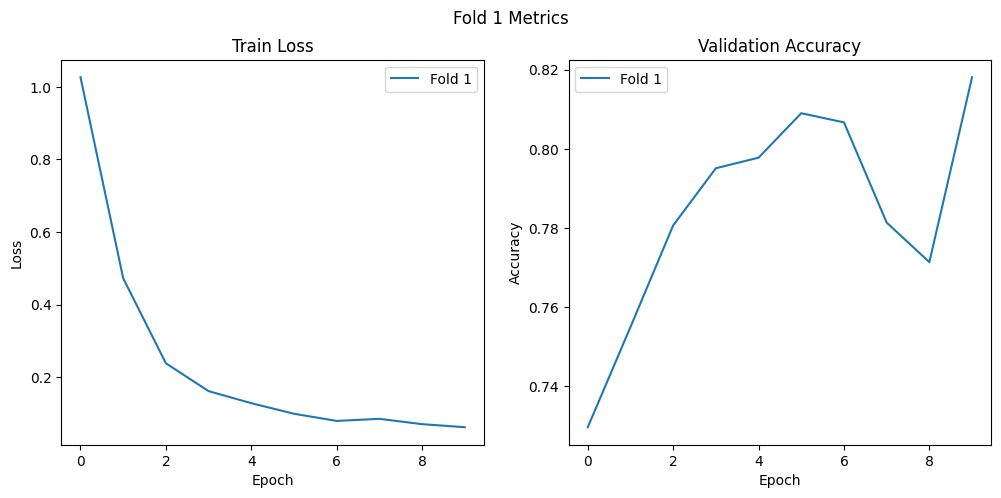

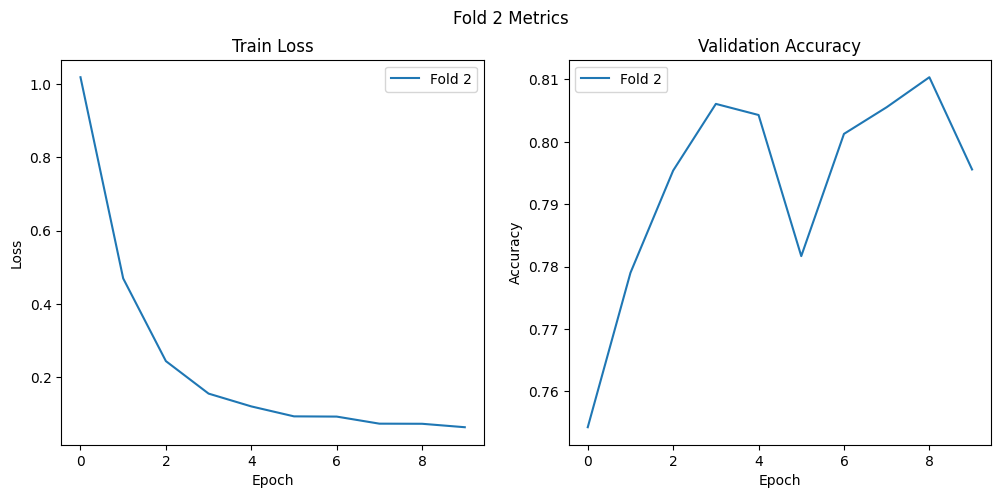

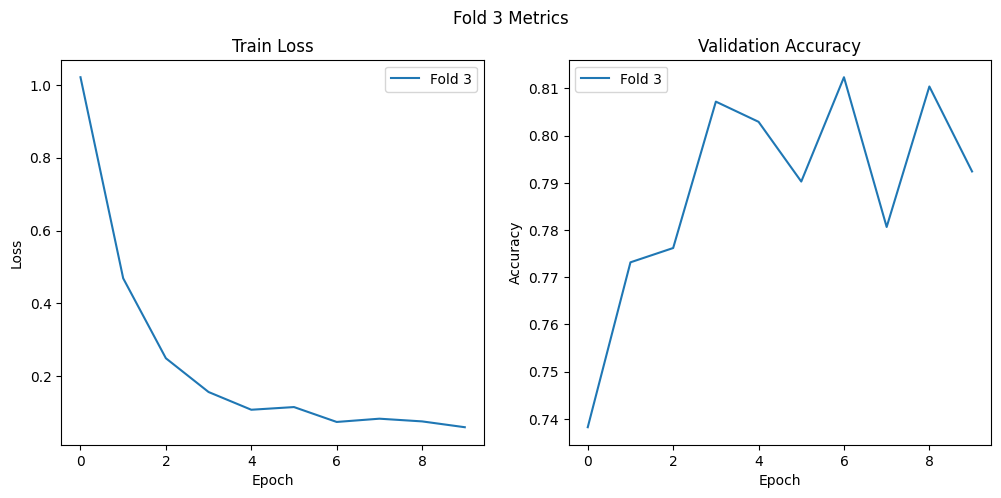

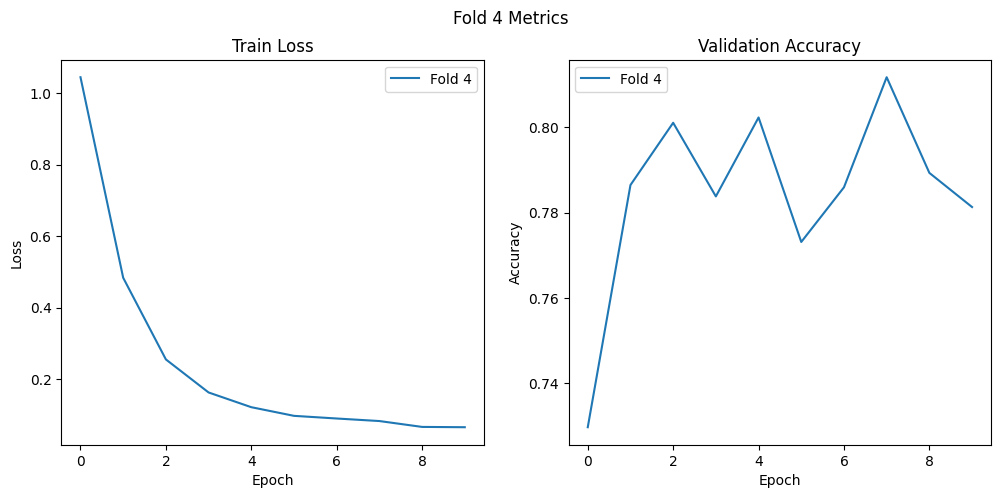

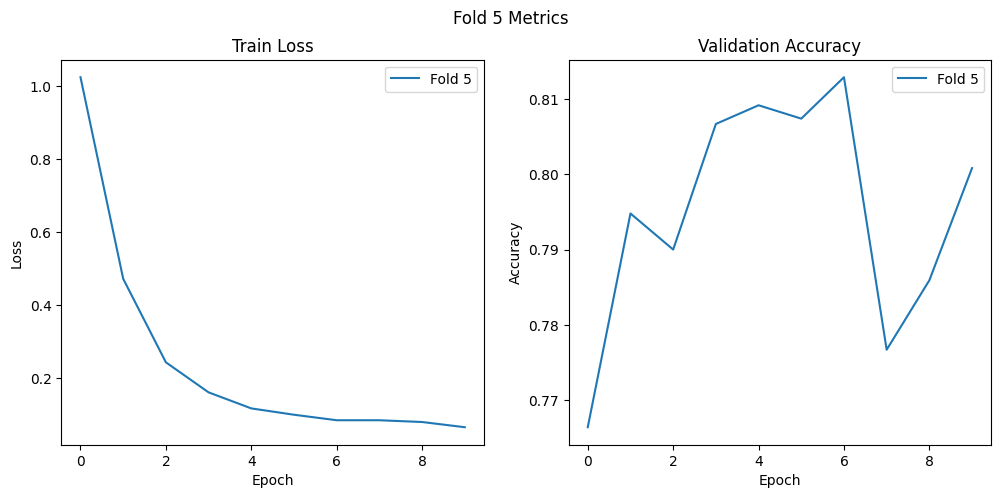

TypeError: cannot unpack non-iterable NoneType object

In [21]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Đảm bảo có danh sách error_paths và data_transforms
    # Ví dụ:
    # error_paths = ["path1", "path2", ...]
    # data_transforms = {
    #     'train': transforms.Compose([...]),
    #     'val': transforms.Compose([...]),
    #     'test': transforms.Compose([...])
    # }

    accuracies, average_accuracy = run_cross_validation(error_paths, data_transforms, device)